# Figure S7: LARRY fate prediction (negative cross entropy)

In [1]:
import larry
import pandas as pd
import ABCParse
import numpy as np
import pathlib
import glob
import pickle
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import sklearn
import matplotlib.pyplot as plt

In [2]:
F_obs = larry.tasks.fate_prediction.F_obs

### CrossEntropy

In [155]:
class CrossEntropy(ABCParse.ABCParse):
    def __init__(self, epsilon: float = 1e-12):
        self.__parse__(locals())
        
    def _augment_cols(self, F_obs, F_hat):
        for col in F_obs:
            if not col in F_hat:
                F_hat[col] = 0
        return F_hat
        
    def _norm(self, df: pd.DataFrame):
        return df.div(df.sum(axis=1), axis = 0)
    
    def _filter_zero_prediction_rows(self, F_obs: pd.DataFrame, F_hat: pd.DataFrame):
        mask = (F_hat.sum(1) > 0).values
#         print(mask.sum())
        F_obs = F_obs.loc[mask]
        F_hat = F_hat.loc[mask]
        return F_obs, F_hat, mask
    
    def __call__(self, F_obs, F_hat):
        
        true = F_obs.copy()
        pred = F_hat.copy()
        
            
        pred = self._augment_cols(F_obs = true, F_hat = pred)
        pred = pred[true.columns.tolist()]
        
#         true, pred, mask = self._filter_zero_prediction_rows(F_obs = true, F_hat = pred)    
        
        true['undiff'] = 0
        pred['undiff'] = 1 - pred.sum(1)
        
        
        pred = pred.clip(lower=self._epsilon)
        true = self._norm(df=true)
        pred = self._norm(df=pred)
        
        
        ce = -np.sum(true.values * np.log(pred.values + self._epsilon), axis=1)       
#         n_cells = mask.sum()
        return np.abs(ce).mean()
    
def cross_entropy(F_obs: pd.DataFrame, F_hat: pd.DataFrame, epsilon: float = 1e-12):
    """"""
    calc = CrossEntropy(epsilon=epsilon)
    return calc(F_obs=F_obs, F_hat=F_hat)

### torch-pba

In [156]:
pba_dir = pathlib.Path("./github/scdiffeq-analyses/manuscript/Figure2/results/fate_prediction/torch_pba/")

In [282]:
DataFrames = {}
for path in list(pba_dir.glob("PBA.F_hat.29SEPT2023*.csv")):
    seed = int(path.name.split("seed_")[1].split(".")[0])
    if seed <= 5:
        DataFrames[seed] = pd.read_csv(path, index_col = 0)
DataFrames = {key: DataFrames[key] for key in sorted(DataFrames)}

In [285]:
import seaborn as sns

In [158]:
TorchPBAResults = {}
for seed, F_hat in DataFrames.items():
    ce = cross_entropy(F_obs, F_hat)
    TorchPBAResults[seed] = {"cross_entropy": ce}
torch_pba = pd.DataFrame(TorchPBAResults).T
torch_pba

,cross_entropy
0,3.035831
1,1.447805
3,1.731142
4,4.889319
5,3.874163


### TIGON

In [177]:
F_hat = pd.read_csv("./experiments/PBA_TIGON_comparison/F_hat.TIGON.csv", index_col = 0)
F_hat.index = F_hat.index.astype(str)
F_hat = F_hat.div(F_hat.sum(1), axis = 0).fillna(0)

In [178]:
ce = cross_entropy(F_obs=F_obs, F_hat=F_hat)
tigon = pd.DataFrame({0: {"cross_entropy": ce}}).T
tigon

,cross_entropy
0,25.872474


### PRESCIENT

In [162]:
pkl_path = "./github/old-scdiffeq-analyses/analyses/figure2/LARRY.fate_prediction/PRESCIENT/prescient_simout.pickle"
f = pd.read_pickle(pkl_path)
DataFrames = {"KEGG+": {}, "KEGG-": {}}
for key, val in f.items():
    seed = int(key[2].split("seed")[1])
    if "no" in key[-1]:
        DataFrames["KEGG-"][seed] = val
    else:
        DataFrames["KEGG+"][seed] = val

#### No weights

In [163]:
PRESCIENTResults = {}
for seed, F_hat in DataFrames['KEGG-'].items():
    ce = cross_entropy(F_obs=F_obs, F_hat=F_hat)
    PRESCIENTResults[seed] = {"cross_entropy": ce}
prescient = pd.DataFrame(PRESCIENTResults).T
prescient

,cross_entropy
1,14.514008
2,15.743406
4,14.705221
0,14.670459
3,15.102966


#### KEGG weights

In [166]:
PRESCIENTKEGGResults = {}
for seed, F_hat in DataFrames['KEGG+'].items():
    ce = cross_entropy(F_obs=F_obs, F_hat=F_hat)
    PRESCIENTKEGGResults[seed] = {"cross_entropy": ce}
prescient_kegg = pd.DataFrame(PRESCIENTKEGGResults).T
prescient_kegg

,cross_entropy
3,12.436500
1,12.226516
0,12.793915
4,12.721861
2,12.494192


### scDiffEq

In [167]:
pkl_path = "./github/old-scdiffeq-analyses/analyses/figure2/LARRY.fate_prediction/scDiffEq/scdiffeq_simout.pickle"
f = pd.read_pickle(pkl_path)
DataFrames = {"KEGG+": {}, "KEGG-": {}}
for key, val in f.items():
    seed = int(key[2].split("seed")[1])
    if "no" in key[-1]:
        DataFrames["KEGG-"][seed] = val
    else:
        DataFrames["KEGG+"][seed] = val

In [170]:
scDiffEqResults = {}
for seed, F_hat in DataFrames['KEGG-'].items():
    ce = cross_entropy(F_obs=F_obs, F_hat=F_hat)
    scDiffEqResults[seed] = {"cross_entropy": ce}
scdiffeq = pd.DataFrame(scDiffEqResults).T

In [173]:
scDiffEqKEGGResults = {}
for seed, F_hat in DataFrames['KEGG+'].items():
    ce = cross_entropy(F_obs=F_obs, F_hat=F_hat)
    scDiffEqKEGGResults[seed] = {"cross_entropy": ce}
scdiffeq_kegg = pd.DataFrame(scDiffEqKEGGResults).T

In [175]:
scdiffeq_kegg

,cross_entropy
3,4.595422
0,8.025012
4,8.347509
1,7.150915
2,8.268369


In [198]:
def _read_process_F_hat(path, pickle=False, filter_nan=True):

    if pickle:
        F_hat = pd.read_pickle(path)[0]
    else:
        F_hat = pd.read_csv(path, index_col=0)
    F_hat_filt = F_hat.copy().drop("Undifferentiated", axis=1)
    F_hat_filt_norm = F_hat_filt.div(F_hat_filt.sum(1), axis=0).fillna(0)
    if filter_nan:
        F_hat_filt_norm = replace_undiff(F_hat_filt_norm)
    F_hat_filt_norm.index = F_obs.index  # F_hat_filt_norm.index.astype(str)
    return F_hat_filt_norm

def replace_undiff(F_hat_filt_norm):

    # create a temp vector to add undiff label
    undiff = np.zeros(len(F_hat_filt_norm))
    replace_idx = np.where(F_hat_filt_norm.sum(1) == 0)
    #     print(f"{replace_idx[0].shape[0]} non-fates")
    undiff[replace_idx] = 1

    # add to normalized matrix
    F_hat_filt_norm["Undifferentiated"] = undiff

    return F_hat_filt_norm

def compute_accuracy(F_obs, F_hat):
    y_true, y_pred = F_obs.idxmax(1).tolist(), F_hat.idxmax(1).tolist()
    return sklearn.metrics.accuracy_score(y_true, y_pred)


def get_organized_results(project_path):
    paths = list(project_path.glob("*/fate_prediction_metrics/*/F_hat.unfiltered.csv"))
    OrgResults = {}
    for path in paths:
        path_ = pathlib.Path(path)
        version = path_.parent.parent.parent.name
        if not version in OrgResults:
            OrgResults[version] = {}
        ckpt_name = path_.parent.name
        F_hat = _read_process_F_hat(path_, pickle=False)
        F_hat.index = F_hat.index.astype(str)
        acc = larry.tasks.fate_prediction.metrics.multi_idx_accuracy(F_obs, F_hat)
        train_acc = acc.loc["unique_train.all_fates"].iloc[0]
        test_acc = acc.loc["unique_test.all_fates"].iloc[0]
        OrgResults[version][ckpt_name] = {"train": train_acc, "test": test_acc}
        acc_ = compute_accuracy(F_obs, F_hat)
    #         print("| Accuracy: Train: {:.5f}, Test: {:.3f} |".format(train_acc, test_acc), version, ckpt_name)
    return OrgResults


def get_best_results(OrgResults):
    BestResults = {}
    for key, val in OrgResults.items():
        version_accuracy = pd.DataFrame(val).T
        best_ckpt = version_accuracy["train"].idxmax()
        best_test = version_accuracy.loc[best_ckpt]["test"]
        #         print(key, best_ckpt, best_test)
        #         best_.append()
        BestResults[key] = best_test

    return BestResults

In [223]:
# scDiffEq + KEGG + RVR=2.5
project_path = pathlib.Path(
    "/home/mvinyard/experiments/fate_prediction.reg_velo/v2/LightningSDE-FixedPotential-RegularizedVelocityRatio"
)
project = sdq.io.Project(project_path)
versions = [
    getattr(project, attr) for attr in project.__dir__() if attr.startswith("version_")
]

best = {}
for version in versions:
    version_accuracy = sdq_an.parsers.VersionAccuracy(version)
    Vr = version.hparams["velocity_ratio_params"]["target"]
    if Vr == 2.5:
        accuracy = version_accuracy.best_test_from_train[["train", "test"]]
        best[version._NAME] = {"accuracy": accuracy, "version": version}


# org_results = get_organized_results(project_path)
# best_results = get_best_results(org_results)

In [257]:
DataFrames = {}
for key, val in best.items():
    ckpt_name = val['accuracy'].name
    epoch = int(ckpt_name.split(".")[0].split("_")[-1])
    F_hat_path = best[key]['version'].ckpts[epoch].path.parent.parent.joinpath(f"fate_prediction_metrics/{ckpt_name}/F_hat.unfiltered.csv")
    F_hat = pd.read_csv(F_hat_path, index_col = 0)
    DataFrames[key] = F_hat

In [263]:
scDiffEq_KEGG_RvR = {}
for key, F_hat in DataFrames.items():
    scDiffEq_KEGG_RvR[int(key.split("_")[1])] = {"cross_entropy": cross_entropy(F_obs, F_hat)}
scdiffeq_rvr = pd.DataFrame(scDiffEq_KEGG_RvR).T

In [264]:
scdiffeq_rvr

,cross_entropy
31,5.233871
33,8.013716
35,4.473833
37,4.628067
39,5.128219


In [271]:
import cellplots as cp

In [298]:
colors = [
    "#9d0610",
    "#ffcc00",
    "#f27f34",
    "#eb5e28",
    "#00b4d8",
    "#0096c7",
    "#0077b6",
]

In [307]:
from typing import Optional, List

In [337]:
class StylishBoxPlot(ABCParse.ABCParse):
    def __init__(
        self,
        colors: Optional[List[str]] = None,
        widths: Optional[float] = None,
        scatter_kw={
            "alpha": 0.8,
            "s": 35,
        },
        *args,
        **kwargs
    ):
        self.__parse__(locals())

    @property
    def colors(self):
        if not hasattr(self, "_colors") or self._colors is None:
            self._colors = list(cm.tab20.colors)
        return self._colors

    def _background_scatter(self, ax, data):
        for en, (key, val) in enumerate(data.items()):

            x = [key] * len(val)

            if len(x) > 1:
                x_vals = en + 1 + (np.random.random(len(x)) - 0.5) / 5
            else:
                x_vals = en + 1

            ax.scatter(
                x_vals,
                val,
                color=self.colors[en],
                zorder=0,
                ec="None",
                rasterized=False,
                **self._scatter_kw,
            )

    def _background_boxplot(self, ax, data):

        x = list(data.keys())
        y = list(data.values())

        x = np.arange(len(y)) + 1

        bp = ax.boxplot(
            y,
            positions=x,
            patch_artist=True,
            showmeans=True,
            showfliers=False,
            meanline=True,
            zorder=1,
            widths=self._widths,
        )
        for median in bp["medians"]:
            median.set_visible(False)
        for en, mean in enumerate(bp["means"]):
            mean.set_c(self.colors[en])

        for en, box in enumerate(bp["boxes"]):
            box.set_facecolor(self.colors[en])
            box.set_alpha(0.2)

        for en, whisker in enumerate(bp["whiskers"]):
            whisker.set_c("None")

        for en, cap in enumerate(bp["caps"]):
            cap.set_c("None")

    def _foreground_boxplot(self, ax, data):

        y = list(data.values())
        x = list(data.keys())
        x = np.arange(len(y)) + 1
        bp = ax.boxplot(
            y,
            positions=x,
            patch_artist=True,
            showmeans=False,
            showfliers=False,
            meanline=False,
            zorder=2,
            widths=self._widths,
        )
        for en, box in enumerate(bp["boxes"]):
            box.set_facecolor("None")
            box.set_edgecolor(self.colors[en])

        colors_ = np.repeat(
            np.array(self.colors), 2, axis=0
        )  # list(np.repeat(self.colors, 2))
        for en, whisker in enumerate(bp["whiskers"]):
            whisker.set_c(colors_[en])

        for en, cap in enumerate(bp["caps"]):
            cap.set_c(colors_[en])

        for median in bp["medians"]:
            median.set_visible(False)

    def __call__(self, ax, data, *args, **kwargs):

        self.__update__(locals())

        try:
            self._background_scatter(ax, data)
        except:
            print(data)
        self._background_boxplot(ax, data)
        self._foreground_boxplot(ax, data)

In [338]:
results = {
    "TorchPBA": torch_pba,
    "TIGON": tigon,
    "PRESCIENT": prescient,
    "PRESCIENT-KEGG": prescient_kegg,
    "scDiffEq": scdiffeq,
    "scDiffEq-KEGG": scdiffeq_kegg,
    "scDiffEq-KEGG-RvR": scdiffeq_rvr
}
results = {key: ABCParse.as_list(val.values.flatten().tolist()) for key, val in results.items()}

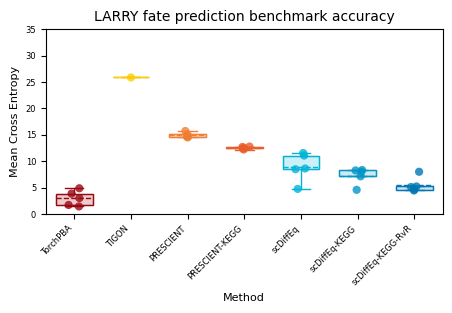

In [341]:
fig, axes = cp.plot(
    height=0.5,
    width=0.8,
    title=["LARRY fate prediction benchmark accuracy"],
    y_label=["Mean Cross Entropy"],
    x_label=["Method"],
)
ax = axes[0]

sbp = StylishBoxPlot(colors=colors, widths=0.65)
sbp(ax, results)
ax.set_ylim(0, 35)
xt = ax.set_xticks(np.arange(1, 8))
xtl = ax.set_xticklabels(list(results.keys()), ha="right", rotation=45)
plt.savefig("LARRY.fate_prediction_benchmark.mean_cross_entropy.svg", dpi=500)